In [20]:
packages <- c(
  "tuneR",      # WAV file processing
  "seewave",    # WAV file processing
  "TSA",        # Periodograms
  "fda.usc",    # Functional data processing
  "plot3D"
)

for (package in packages) {
  if (!requireNamespace(package, quietly = TRUE)) {
    install.packages(package)
  }

  library(package, character.only = TRUE)
}

In [2]:
get_filepaths <- function(dir, subset) {
  return(file.path(dir, readLines(file.path(dir, subset))))
}

dataset_dir <- "SpeechCommands"
train_paths <- get_filepaths(dataset_dir, "train.txt")
val_paths <- get_filepaths(dataset_dir, "val.txt")
test_paths <- get_filepaths(dataset_dir, "test.txt")

sample_test_paths <- function(paths, n_per_class) {
  # Extract class labels from file paths
  labels <- sapply(paths, function(p) strsplit(p, "/")[[1]][2])
  
  # Create a data frame with paths and labels
  df <- data.frame(Path = paths, Label = labels, stringsAsFactors = FALSE)
  
  # Sample n_per_class paths for each label
  sampled_paths <- do.call(rbind, lapply(split(df, df$Label), function(group) {
    group[sample(1:nrow(group), min(n_per_class, nrow(group))), , drop = FALSE]
  }))
  
  return(sampled_paths$Path)
}

# Example usage: sample 5 paths per class from test_paths
test_paths <- sample_test_paths(test_paths, 300)
train_paths <- sample_test_paths(train_paths, 300)

sample_count <- data.frame(
  Subset = c("Train", "Validation", "Test"),
  Utterances = c(length(train_paths), length(val_paths), length(test_paths))
)
sample_count

Subset,Utterances
<chr>,<int>
Train,3000
Validation,3338
Test,3000


In [3]:
load_audio_as_fdata <- function(filepath, func = mean) {
  audio <- tuneR::readWave(filepath)
  signal <- audio@left

  # Center the signal
  signal <- signal - mean(signal)

  pgram <- TSA::periodogram(signal, plot = FALSE)
  log_pgram <- log(pgram$spec + 1e-10)
  freqs <- pgram$freq * audio@samp.rate / 1000

  # Interpolate the log periodogram onto a coarser grid
  reduced_freqs <- seq(min(freqs), max(freqs), length.out = 800)
  log_pgram <- approx(x = freqs, y = log_pgram, xout = reduced_freqs)$y

  fdata_obj <- fda.usc::fdata(
    matrix(log_pgram, nrow = 1),
    argvals = reduced_freqs,
    rangeval = range(reduced_freqs),
    names = list(
      main = "Google Speech Commands",
      xlab = "Frequencies (kHz)",
      ylab = "log(Power)"
    )
  )

  return(fdata_obj)
}

load_dataset <- function(filepaths) {
  fdata_list <- list()
  labels <- c()

  for (filepath in filepaths) {
    # Extract class label from file path
    label <- strsplit(filepath, "/")[[1]][2]

    fdata_list[[filepath]] <- load_audio_as_fdata(filepath)
    labels <- c(labels, label)
  }

  # Convert list of fdata objects to single fdata object
  fdata <- do.call(c, fdata_list)

  # Convert class labels to factor
  labels <- factor(labels, levels = c(
    "zero", "one", "two", "three", "four",
    "five", "six", "seven", "eight", "nine"
  ))

  return(list(data = fdata, labels = labels))
}

dataset <- load_dataset(test_paths)
dataset2 <- load_dataset(train_paths)

In [4]:
nw <- fda.usc::optim.np(
  dataset$data,
  type.S = S.NW,
  par.CV = list(criteria = "GCV")
)
nw2 <- fda.usc::optim.np(
  dataset2$data,
  type.S = S.NW,
  par.CV = list(criteria = "GCV")
)

In [5]:
# Function to plot the p-value matrix
plot_p_value_matrix <- function(p_matrix) {
  # Replace any NA, NaN, or Inf values with very small values for plotting
  p_matrix[!is.finite(p_matrix)] <- 1e-10
  
  # Convert to -log10(p) for better visualization (higher values = more significant)
  log_p_matrix <- -log10(p_matrix)
  
  # Cap extremely large values for better color scale
  max_val <- 6  # Cap at -log10(p) = 6 (p = 0.000001)
  log_p_matrix[log_p_matrix > max_val] <- max_val
  
  # Make sure diagonal is exactly 0 (p-value of 1)
  # diag(log_p_matrix) <- 0
  
  # Create color palette for visualization
  colors <- colorRampPalette(c("white", "yellow", "orange", "red"))(100)
  
  # Create breaks for the color scale (one more than number of colors)
  breaks <- seq(0, max_val, length.out = 101)
  
  # Plot the matrix
  par(mar = c(5, 5, 4, 2) + 0.1)  # Increase margins for labels
  
  digits <- as.numeric(factor(rownames(p_matrix), levels = c("zero", "one", "two", "three", "four", 
                                                             "five", "six", "seven", "eight", "nine"))) - 1
  
  
  image(1:ncol(log_p_matrix), 1:nrow(log_p_matrix), log_p_matrix,
        col = colors,
        breaks = breaks,
        axes = FALSE,
        xlab = "Digit (Reference)",
        ylab = "Digit (Test)",
        main = "Pairwise Significance (-log10 p-values)")
  
  # Add axis labels and grid
  axis(1, at = 1:ncol(log_p_matrix), labels = digits)
  axis(2, at = 1:nrow(log_p_matrix), labels = digits)
  grid(nx = ncol(log_p_matrix), ny = nrow(log_p_matrix), col = "lightgray", lty = "solid")
  
  # Add color scale legend with meaningful p-values
  par(new = TRUE)
  plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", xlab = "", ylab = "")
  
  legend_values <- c(1, 0.1, 0.01, 0.001, 0.0001, 0.00001)
  legend_colors <- colorRampPalette(c("white", "yellow", "orange", "red"))(length(legend_values))
  
  legend("topright",
         legend = as.character(legend_values),
         fill = legend_colors,
         title = "p-value",
         bty = "n")
}

In [6]:
nw_fd_list <- lapply(c("zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"), function(label) {
    fda.usc::fdata2fd(nw$fdata.est[which(dataset$labels == label), ])
})
names(nw_fd_list) <- c("zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine")

nw2_fd_list <- lapply(c("zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"), function(label) {
    fda.usc::fdata2fd(nw2$fdata.est[which(dataset2$labels == label), ])
})
names(nw2_fd_list) <- c("zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine")

In [7]:
L2.stat.twosample<-function(x,y,t.seq, alpha=0.05){
    if(class(x)!= "fd") stop("Xmustbefdobject")
    if(class(y)!= "fd") stop("Ymustbefdobject")

    mu.x <- mean.fd(x)
    mu.y <- mean.fd(y)

    n <- dim(x$coefs)[2]
    m <- dim(y$coefs)[2]

    k <- length(t.seq)

    cn <- (n*m)/(n+m)
    delta <- (mu.x-mu.y)
    delta.t <- eval.fd(t.seq,delta)

    z.x <- center.fd(x)
    z.y <- center.fd(y)

    z.x.t <- eval.fd(t.seq,z.x)
    z.y.t <- eval.fd(t.seq,z.y)
    z.t <- cbind(z.x.t,z.y.t)

    if(n> k |m >k){
        Sigma <- (t(z.t)%*%z.t)/(n-2)
    } else{
        Sigma <- (z.t%*% t(z.t))/(n-2)
    }

    A <- sum(diag(Sigma))
    B <- sum(diag(Sigma^2))

    L2stat <- cn *t(delta.t) %*%delta.t
    L2stat <- L2stat[1]

    A2 <- A^2
    B2 <- B
    alp <- B2/A
    df <- A2/B2
    pvalue <-1-pchisq(L2stat/alp,df)
    params <-list(alpha= alp,df= df)

    return(list(statistics= L2stat,pvalue=pvalue, params=params))
}

In [8]:
F.stat.twosample <- function(x, y, t.seq, alpha=0.05) {
    if(class(x) != "fd") stop("X must be fd object")
    if(class(y) != "fd") stop("Y must be fd object")

    mu.x <- mean.fd(x)
    mu.y <- mean.fd(y)

    n <- dim(x$coefs)[2]
    m <- dim(y$coefs)[2]

    k <- length(t.seq)

    cn <- (n*m)/(n+m)
    delta <- (mu.x- mu.y)
    delta.t <- eval.fd(t.seq, delta)

    z.x <- center.fd(x)
    z.y <- center.fd(y)

    z.x.t <- eval.fd(t.seq, z.x)
    z.y.t <- eval.fd(t.seq, z.y)
    z.t <- cbind(z.x.t, z.y.t)

    if(n > k | m > k) {
        Sigma <- (t(z.t) %*% z.t)/(n-2)
    } else {
        Sigma <- (z.t %*% t(z.t))/(n-2)
    }
    
    A <- sum(diag(Sigma))
    B <- sum(diag(Sigma^2))

    Fstat <- (cn * t(delta.t) %*% delta.t)/A
    Fstat <- Fstat[1]
    
    kappa <- A^2/B
    pvalue <- 1-pf(Fstat, kappa, (n-2)*kappa)
    params <- list(df1 = kappa, df2 = (n-2)*kappa)
    return(list(statistics = Fstat, pvalue = pvalue, params=params))
}

In [9]:
pvalue_matrix_func <- function(test_func, t.seq) {
    pvalue_matrix <- matrix(NA, nrow = 10, ncol = 10)
    rownames(pvalue_matrix) <- c("zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine")
    colnames(pvalue_matrix) <- c("zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine")

    # Compute p-values for all pairwise comparisons
    for (i in 0:9) {
        for (j in 0:9) {
            fd_i <- nw_fd_list[[i + 1]]
            fd_j <- nw2_fd_list[[j + 1]]

            pvalue_matrix[i + 1, j + 1] <- test_func(fd_i, fd_j, t.seq, alpha = 0.05)$pvalue
        }
    }
    plot_p_value_matrix(pvalue_matrix)
}

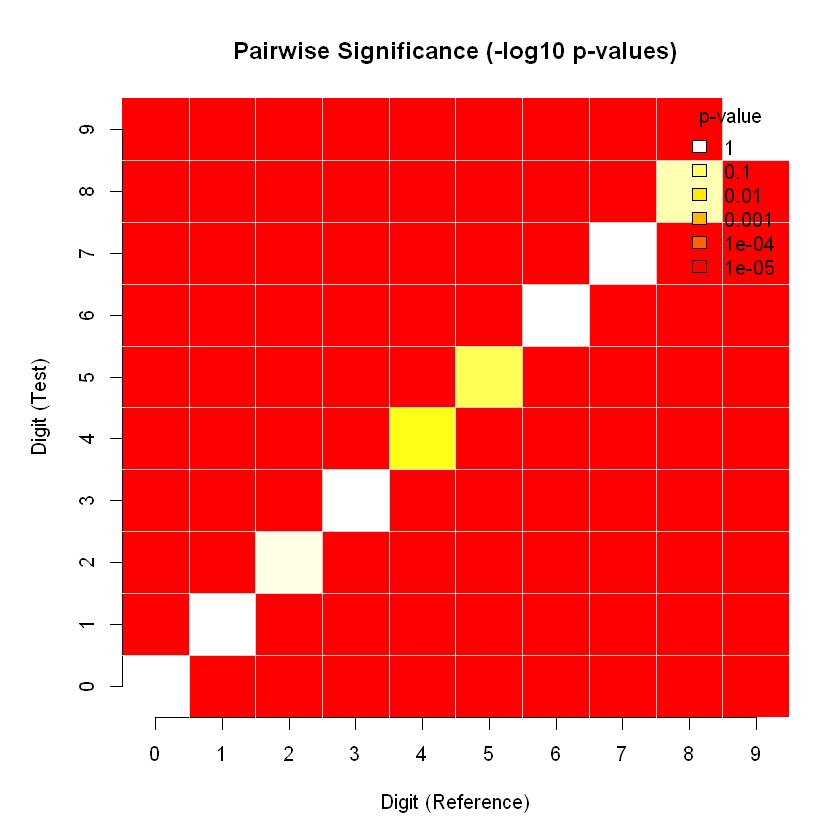

In [12]:
freq_range <- nw$fdata.est$argvals
freq_range <- freq_range[freq_range >= 0 & freq_range <= 8]
pvalue_matrix_func(L2.stat.twosample, freq_range)

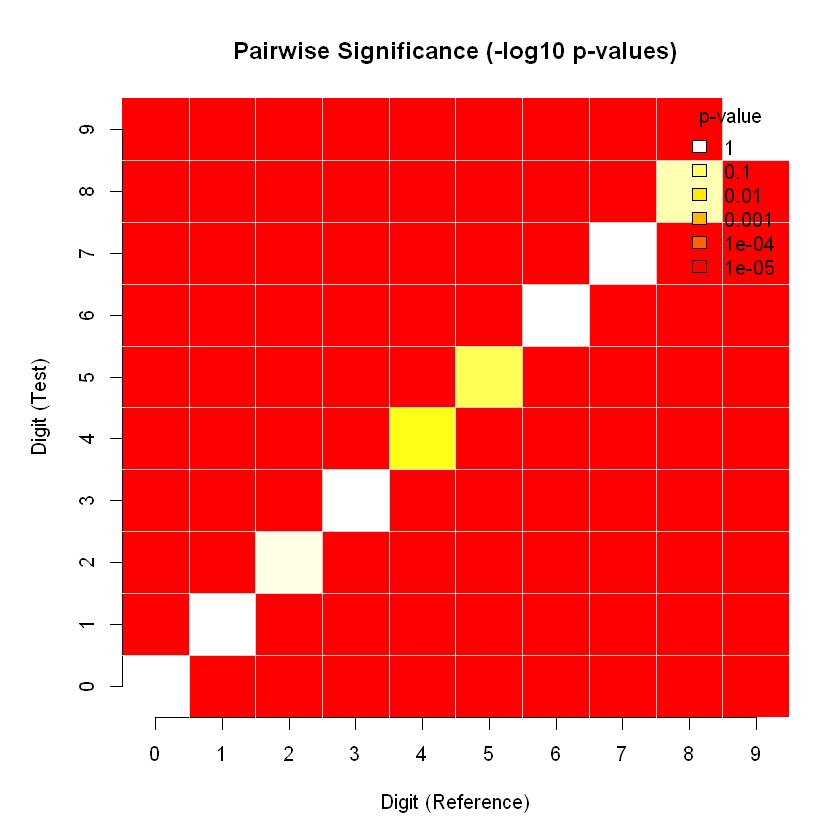

In [13]:
pvalue_matrix_func(F.stat.twosample, freq_range)

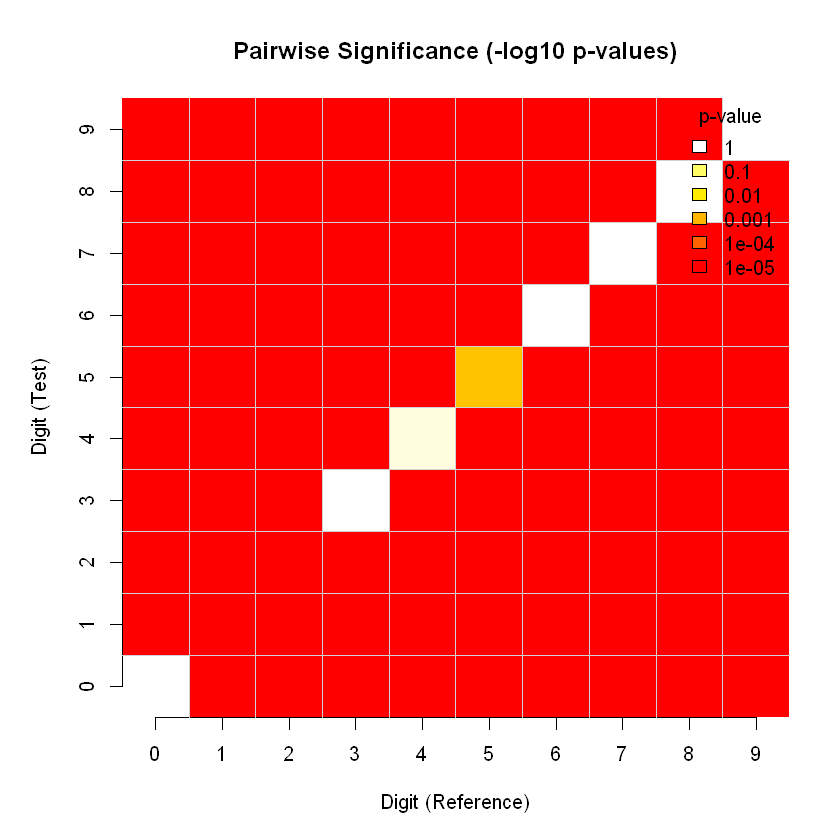

In [14]:
freq_range <- nw$fdata.est$argvals
freq_range <- freq_range[freq_range >= 0 & freq_range <= 2]
pvalue_matrix_func(L2.stat.twosample, freq_range)

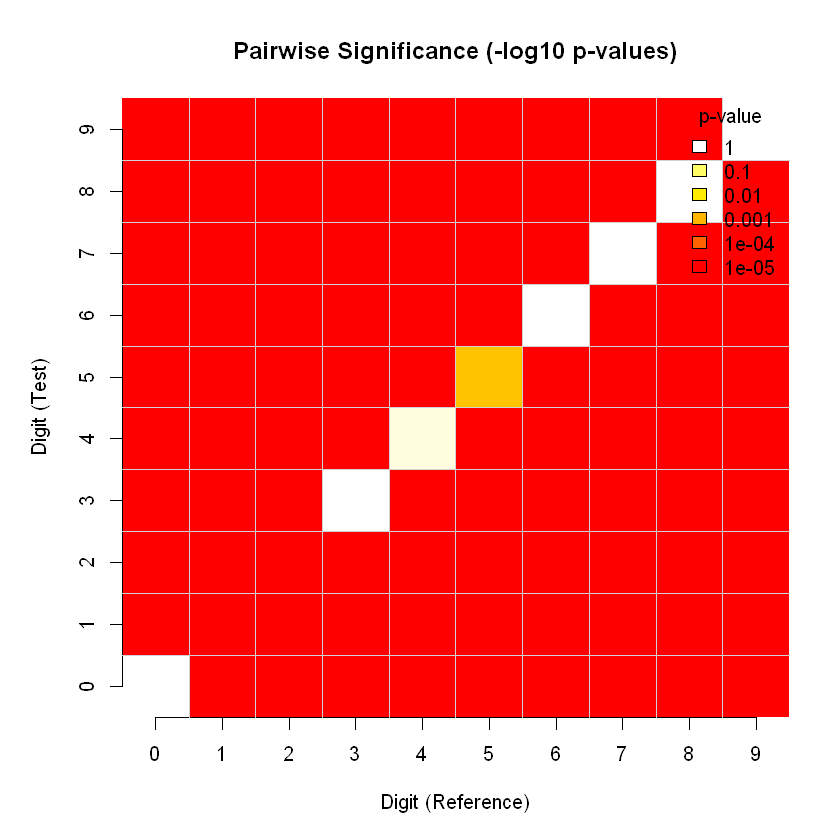

In [15]:
pvalue_matrix_func(F.stat.twosample, freq_range)

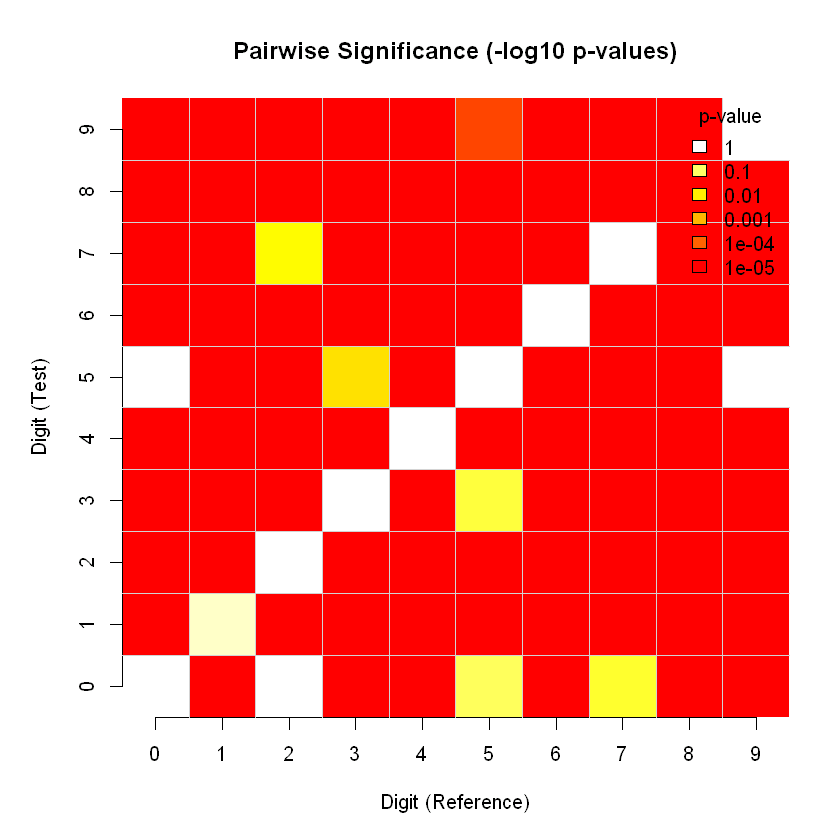

In [16]:
freq_range <- nw$fdata.est$argvals
freq_range <- freq_range[freq_range >= 2 & freq_range <= 4]
pvalue_matrix_func(L2.stat.twosample, freq_range)

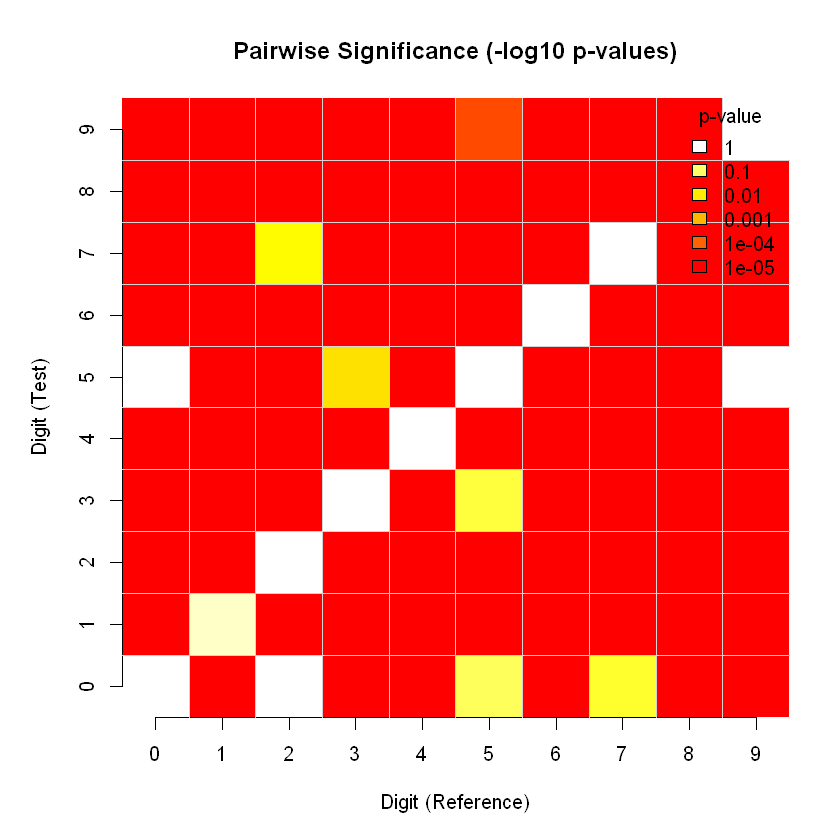

In [17]:
pvalue_matrix_func(F.stat.twosample, freq_range)

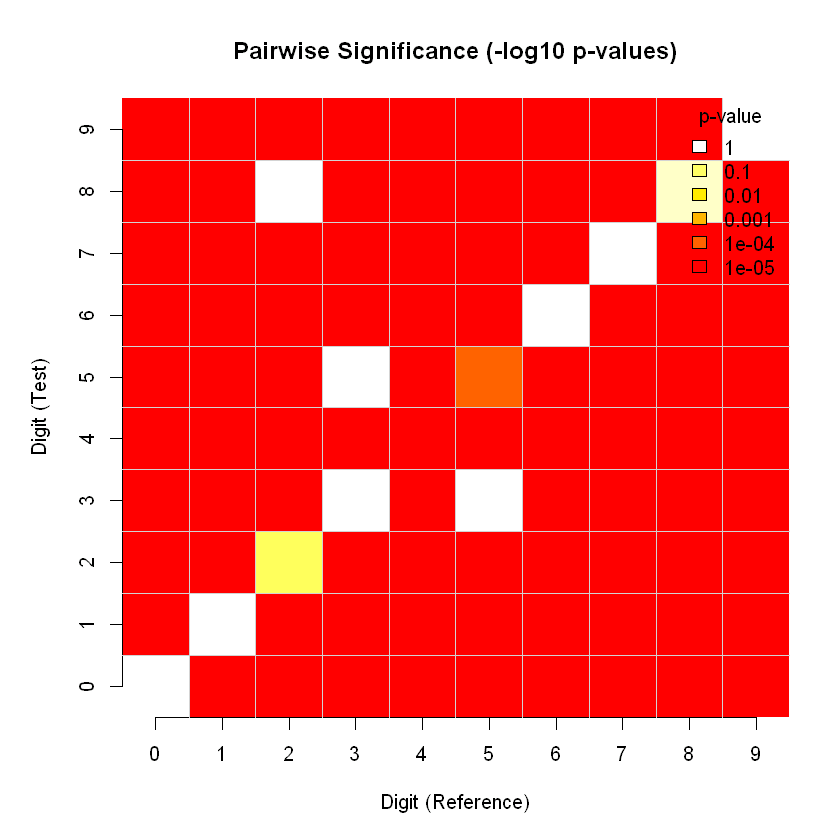

In [18]:
freq_range <- nw$fdata.est$argvals
freq_range <- freq_range[freq_range >= 4 & freq_range <= 8]
pvalue_matrix_func(L2.stat.twosample, freq_range)

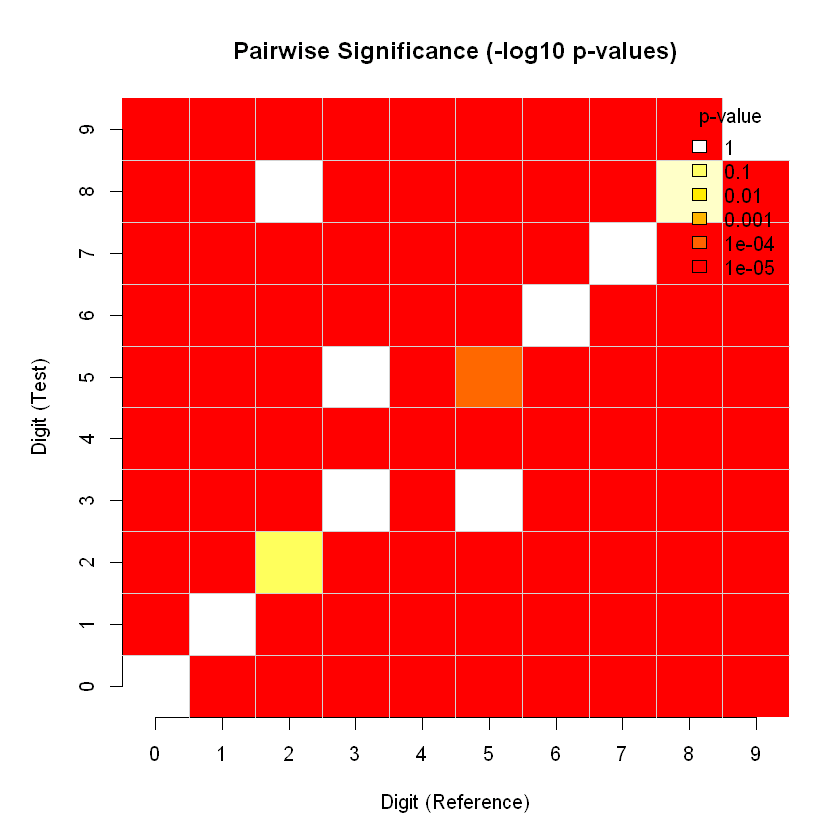

In [19]:
pvalue_matrix_func(F.stat.twosample, freq_range)